# Test formation of quasicrystal by projection of high-dimensional unit cells

In [1]:
%matplotlib inline
from neurotools.nlab import *

Loading nlab namespace
Could not locate the spectrum module, please install it
Multitaper methods will not work
Could not locate the spectrum module, please install it
Multitaper methods will not work


In [2]:
# Dimensionality
M = 7

# Scale 
K = 3

# Unit vectors
units = exp(1j*arange(M)*pi/M)

In [3]:
# Generate a collection of paths in M dimensions
# Use the unit vector projection to identify the point location
# TODO: we need a better datastructure for detecting identical points
# I don't know how to do this theoretically unless they occupy
# The same location in the higher-dimensional lattice?

In [4]:
class Pointset():
    '''
    Behaves like a set, but instead of equality, 
    uses a proximity threshold to determine whether
    two points are the same.
    '''
    def __init__(self):
        self.N = 20 # Size of point storage
        self.K = 0  # Number stored points
        self.storage = np.zeros((self.N,),dtype=np.complex128)
        self.counts  = np.zeros((self.N,),dtype=np.int64)
        self.eps = 1e-8 # tolerance for considering two points the same
    def add(self,point):
        distance = np.abs(point-self.storage)
        mini = np.argmin(distance)
        if distance[mini]<=self.eps:
            # Point is close to existing point, do not add it
            # Replace point with a value representing the mean
            # We should also track counts, shouldn't we?
            npoints = self.counts [mini]
            z       = self.storage[mini]
            self.storage[mini] = (z*npoints+point)/(npoints+1)
            self.counts[mini] += 1
        else:
            # Point is not close to existing point, add it
            # If we nede more space, make it
            if self.K>=self.N:
                self.N = self.N*2
                newstore = np.zeros((self.N,),dtype=np.complex128)
                newcounts = np.zeros((self.N,),dtype=np.int64)
                newstore[:self.K]  = self.storage
                newcounts[:self.K] = self.counts
                self.storage = newstore
                self.counts  = newcounts
            assert self.K<self.N
            self.storage[self.K]=point
            self.counts [self.K]=1
            self.K +=1

In [5]:
# Generate points using unit vectors
import itertools
cycle = arange(-K,K+1)
generated = [cycle]*M

points = Pointset()

for v in itertools.product(*generated):
    z = array(v).dot(units)
    if abs(z)<K:
        points.add(z)


In [6]:
def z2xy(z):
    return z.real,z.imag

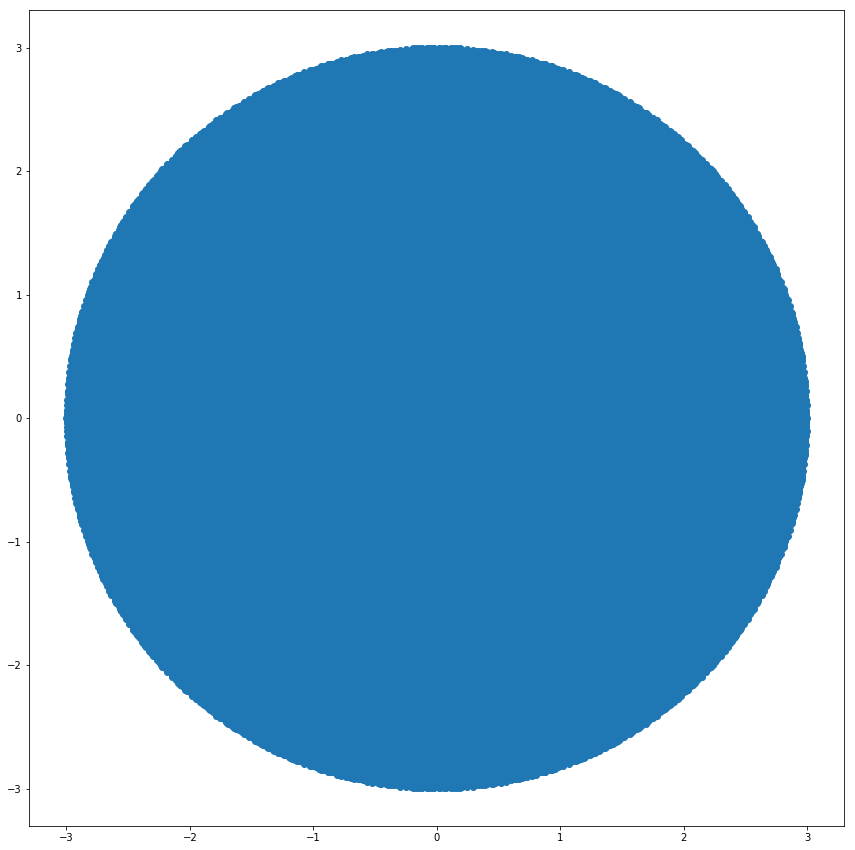

In [7]:
figure(figsize=(15,15))
scatter(*z2xy(points.storage))
force_aspect()

In [8]:
from collections import defaultdict

def z2xy(z):
    '''
    Converts an array of complex numbers into two arrays
    representing real and imaginary parts, respectively.
    '''
    return real(z),imag(z)

def uniquerow(x):
    '''
    Removes duplicate rows from a 2D numpy array
    '''
    return array(list(set(map(tuple,x))))

def trianglesToEdges(triangles):
    '''
    Accepts Ntriangles x 3 array of triangle indeces, like the format
    returned by `scipy.spatial.Delaunay(...).simplices`. Returns a
    Nedges x 2 numpy array of unique edges in the triangulation
    '''
    tedges    = triangles[:,[0,1,1,2,2,0]].reshape((size(triangles),2))
    tedges    = uniquerow(sort(tedges,axis=1))
    return tedges

def edgesNearby(iz,microd):
    '''
    Returns a dictionary mapping from 
    indecies into point list iz 
    (2d locations passed as x+iy complex)
    to a list of nearby point indices
    
    Computed by thresholding delaunay triangulation
    '''
    points    = array([real(iz),imag(iz)])
    triangles = scipy.spatial.Delaunay(points.T).simplices
    tedges    = trianglesToEdges(triangles)
    edgelen   = ravel(abs(diff(iz[tedges],axis=1)))
    tedges    = tedges[edgelen<microd,:]
    
    #tedges = concatenate([tedges,tedges[:,[1,0]]])
    #coordsparse = scipy.sparse.coo_matrix((ones(tedges.shape[0]),(tedges[:,0],tedges[:,1])))
    #edgelist = scipy.sparse.csr_matrix(coordsparse)
    
    edgelist  = defaultdict(set)
    for i,z in enumerate(iz):
        edgelist[i] = tuple(ravel(tedges[(tedges==i)[:,[1,0]]]))   
    
    return edgelist

def coalesce(iz,edgelist):
    '''
    Joint connected components as defined in edgelist, and return the centroids
    taken as an average of all point locations in list iz 
    (2d locations passed as x+iy complex)
    '''
    components = {}
    for i in arange(len(iz)):
        components[i]=i
        for e in edgelist[i]:
        #for e in scipy.sparse.find(edgelist[i])[1]:
            if e in components:
                components[i]=components[e]
                break
    componentlist = defaultdict(set)
    for e,cid in components.items():
        componentlist[cid]|={e}
    component_ids = sorted(list(set(components.values())))
    centroids = array([mean(iz[array(list(componentlist[cid]))]) for cid in component_ids])
    return centroids

def plot_edges(iz,edges,**kwargs):
    '''
    Plots a set of edges given by 2d complex numbers and Nedges x 2 array of edge indices
    keword arguments are forwarded to matplotlib.plot
    '''
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()
    
def plot_triangles(iz,triangles,**kwargs):
    '''
    '''
    edges = trianglesToEdges(triangles)
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()

(-1.5, 1.5)

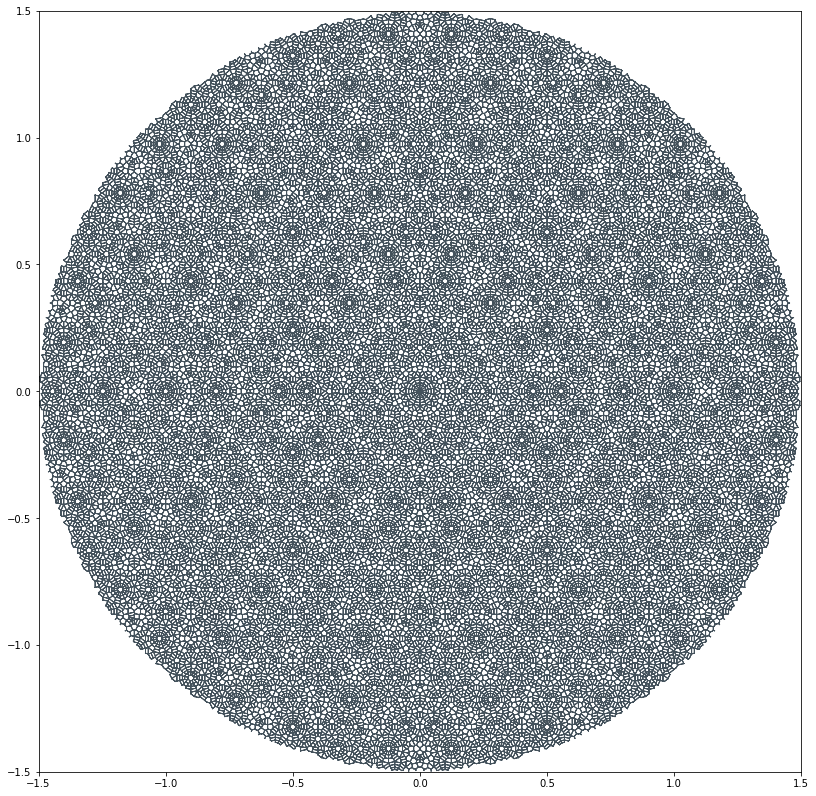

In [9]:
centroids = points.storage[:points.K]

from scipy.spatial import Voronoi, voronoi_plot_2d
pp = array([real(centroids),imag(centroids)])
vor = Voronoi(pp.T,qhull_options="Qc")
vor.regions
vor.point_region
v = vor.vertices
v = v[:,0]+1j*v[:,1]
r = array( vor.regions)

figure(figsize=(14,14))
ee = concatenate([array(list(zip(array(e)[arange(-1,len(e))],e))) for e in r])
vmask = array(v)

okedges = diff(vmask[ee],1,1)[:,0]<1
vmask[abs(vmask)>K/2]=NaN

plot_edges(vmask,ee[okedges,:],color=BLACK,lw=1)

xlim(-K/2,K/2)
ylim(-K/2,K/2)

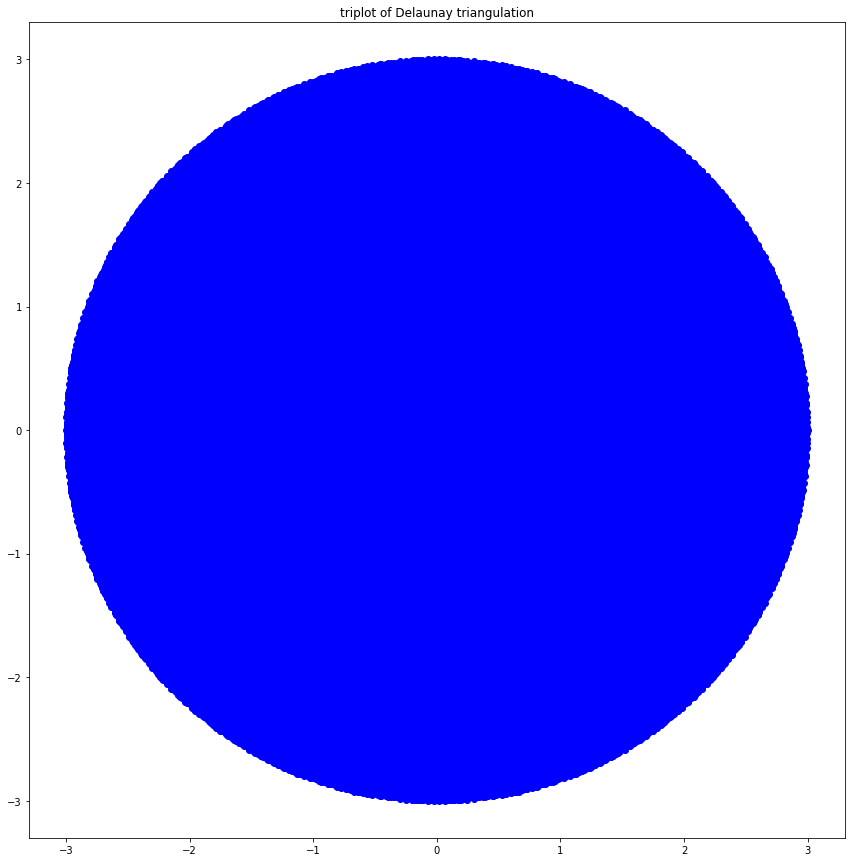

In [10]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import math

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(pp[0],pp[1])

# Plot the triangulation.
plt.figure(figsize=(15,15))
plt.gca().set_aspect('equal')
plt.triplot(triang, 'bo-', lw=1)
plt.title('triplot of Delaunay triangulation')


In [11]:
triang.triangles.shape

(234966, 3)